In [108]:
# Define base paths
base_dir = Path.cwd()
dino_dir = base_dir / "Dino"
resnet_dir = base_dir / "ResNet50"
otf_dir = base_dir / "results_DinoV2-on-the-fly"

# Output directories
out_root = base_dir / "analysis_output_notebook"
plots_dir = out_root / "plots"
tables_dir = out_root / "tables"

def ensure_dir(p):
    """Create directory if it doesn't exist"""
    p.mkdir(parents=True, exist_ok=True)

def load_json(path):
    """Load JSON file"""
    with open(path, "r") as f:
        return json.load(f)

def find_first(pattern):
    """Find first file matching pattern"""
    xs = glob(pattern)
    return Path(xs[0]) if xs else None

ensure_dir(plots_dir)
ensure_dir(tables_dir)
print(f"✓ Base directory: {base_dir}")
print(f"✓ Output directory: {out_root}")

✓ Base directory: c:\Users\filip\Desktop\results_inference\results_inference
✓ Output directory: c:\Users\filip\Desktop\results_inference\results_inference\analysis_output_notebook


## 2. Setup Paths and Utility Functions

In [187]:
import json
from pathlib import Path
from glob import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Configure matplotlib for better-looking plots
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Import Required Libraries

# Ego-Exo Correspondence Analysis
## Interactive Analysis Notebook

This notebook recreates all plots and tables from `analysis.py` and `analysis_2.py` with individual cells for each visualization.

**Experiments covered:**
- Dino (DINOv2 / DINOv3 precomputed features)
- ResNet50 + DINOv1
- DINOv2 on-the-fly
- Comparative analyses

## 3. Core Plotting Functions

In [188]:
def plot_iou_distribution(series_dict, title, save_path=None):
    """Histogram-based IoU density curves on a log y-scale."""
    plt.figure(figsize=(8, 4.5))
    bins = np.linspace(0.0, 1.0, 40)
    
    for label, vals in series_dict.items():
        if vals is None or len(vals) == 0:
            continue
        vals = np.clip(np.asarray(vals, dtype=float), 0.0, 1.0)
        density, bin_edges = np.histogram(vals, bins=bins, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        density = np.maximum(density, 1e-4)
        plt.plot(bin_centers, density, linewidth=3, label=label)
    
    plt.yscale("log")
    plt.ylim(1e-2, None)
    plt.title(title)
    plt.xlabel("IoU")
    plt.ylabel("Density (log scale)")
    plt.legend()
    plt.grid(alpha=0.3)
    
    if save_path:
        ensure_dir(save_path.parent)
        plt.tight_layout()
        plt.savefig(save_path, dpi=180)
    plt.show()

def plot_iou_cdf(series_dict, title, save_path=None):
    """Cumulative IoU distribution: P(IoU <= x)"""
    plt.figure(figsize=(8, 4.5))
    
    for label, vals in series_dict.items():
        if vals is None or len(vals) == 0:
            continue
        vals = np.clip(np.asarray(vals, dtype=float), 0.0, 1.0)
        sorted_vals = np.sort(vals)
        cdf = np.linspace(0.0, 1.0, len(sorted_vals), endpoint=False)
        plt.plot(sorted_vals, cdf, linewidth=3.0, label=label)
    
    plt.title(title)
    plt.xlabel("IoU")
    plt.ylabel("CDF: P(IoU ≤ x)")
    plt.grid(alpha=0.3)
    plt.legend()
    
    if save_path:
        ensure_dir(save_path.parent)
        plt.tight_layout()
        plt.savefig(save_path, dpi=180)
    plt.show()

def plot_iou_kde(series_dict, title, save_path=None, bw_method="scott", log_y=True):
    """Smooth IoU density curves using KDE."""
    plt.figure(figsize=(8, 4.5))
    xs = np.linspace(0.0, 1.0, 400)
    
    for label, vals in series_dict.items():
        if vals is None or len(vals) == 0:
            continue
        vals = np.clip(np.asarray(vals, dtype=float), 0.0, 1.0)
        kde = gaussian_kde(vals, bw_method=bw_method)
        density = kde(xs)
        density = np.maximum(density, 1e-6)
        plt.plot(xs, density, linewidth=3.0, label=label)
    
    if log_y:
        plt.yscale("log")
    plt.title(title)
    plt.xlabel("IoU")
    plt.ylabel(f"Density{' (log scale)' if log_y else ''}")
    plt.grid(alpha=0.3)
    plt.legend()
    
    if save_path:
        ensure_dir(save_path.parent)
        plt.tight_layout()
        plt.savefig(save_path, dpi=180)
    plt.show()

print("✓ Plotting functions defined")

✓ Plotting functions defined


In [285]:
def plot_divergent_iou(model_label, baseline, finetuned, save_path=None):
    """Distribution of per-observation ΔIoU (finetuned − baseline)."""
    n = 1950
    if n == 0:
        print(f"No data for {model_label}")
        return
    
    diff = finetuned[:n] - baseline[:n]
    bins = np.linspace(-1.0, 1.0, 81)
    counts, bin_edges = np.histogram(diff, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    fig, ax1 = plt.subplots(figsize=(8, 4.5))
    
    width = bin_edges[1] - bin_edges[0]
    ax1.bar(bin_centers, counts, width=width, alpha=0.4, label="Histogram")
    ax1.set_yscale("log")
    ax1.set_ylabel("Count (log scale)")
    ax1.axvline(0.0, color="k", linestyle="--", linewidth=3)
    
    ax2 = ax1.twinx()
    sorted_diff = np.sort(diff)
    cdf = np.linspace(0.0, 1.0, len(sorted_diff), endpoint=False)
    ax2.step(sorted_diff, cdf, where="post", label="Empirical CDF", color="C1", linewidth=3)
    ax2.set_ylabel("Cumulative probability")
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    
    ax1.set_xlabel("Δ IoU (finetuned − baseline)")
    ax1.set_title(
        f"Δ IoU distribution – {model_label}\n"
        f"N={n}, mean Δ={diff.mean():.3f}, median Δ={np.median(diff):.3f}"
    )
    
    if save_path:
        ensure_dir(save_path.parent)
        plt.tight_layout()
        plt.savefig(save_path, dpi=180)
    plt.show()

def plot_training_curves(model_label, train_losses, val_losses, val_metrics=None, save_dir=None):
    """Plot training and validation curves."""
    n_epochs = len(train_losses)
    if n_epochs == 0:
        print(f"No training data for {model_label}")
        return
    
    epochs = np.arange(1, n_epochs + 1)
    
    # Loss plot
    plt.figure(figsize=(8, 4.5))
    plt.plot(epochs, train_losses, label="train loss", linewidth=3)
    if len(val_losses) == n_epochs:
        plt.plot(epochs, val_losses, label="val loss", linewidth=3)
    plt.title(f"Loss over epochs – {model_label}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Expand y-axis range on lower end
    ymin, ymax = plt.ylim()
    y_range = ymax - ymin
    plt.ylim(ymin - 0.1 * y_range, ymax)
    
    if save_dir:
        ensure_dir(save_dir)
        plt.tight_layout()
        plt.savefig(save_dir / f"{model_label.replace(' ', '_')}_loss.png", dpi=180)
    plt.show()
    
    # Metric plots
    if val_metrics:
        for metric_key, pretty_name in [
            ("iou", "IoU"),
            ("location_score", "Location Score"),
            ("balanced_acc", "Balanced Accuracy"),
        ]:
            if all(metric_key in e for e in val_metrics):
                values = np.array([e[metric_key] for e in val_metrics], dtype=float)
                ep = epochs[:len(values)]
                
                plt.figure(figsize=(8, 4.5))
                plt.plot(ep, values, linewidth=3)
                plt.title(f"{pretty_name} over epochs – {model_label}")
                plt.xlabel("Epoch")
                plt.ylabel(pretty_name)
                plt.grid(alpha=0.3)
                
                # Expand y-axis range on lower end
                ymin, ymax = plt.ylim()
                y_range = ymax - ymin
                plt.ylim(ymin - 0.7 * y_range, ymax)
                
                if save_dir:
                    plt.tight_layout()
                    plt.savefig(save_dir / f"{model_label.replace(' ', '_')}_{metric_key}.png", dpi=180)
                plt.show()

print("✓ Additional plotting functions defined")

✓ Additional plotting functions defined


## 4. Load All Evaluation Data

In [286]:
def load_eval_metrics(eval_dir, label):
    """Load evaluation metrics from results_metrics_run_*.json"""
    metrics_path = find_first(str(eval_dir / "results_metrics_run_*.json"))
    if not metrics_path:
        print(f"⚠ No metrics found in {eval_dir}")
        return None
    
    js = load_json(metrics_path)
    agg = js.get("aggregated_metrics", {})
    per_obs = js.get("per_observation_metrics", {})
    ious = np.array(per_obs.get("iou_per_obs", []), dtype=float)
    
    return {
        "label": label,
        "path": metrics_path,
        "mean_iou": float(agg.get("iou", np.nan)),
        "iou_std": float(np.std(ious)) if len(ious) > 0 else float(agg.get("iou_std", np.nan)),
        "shape_acc": float(agg.get("shape_acc", np.nan)),
        "location_score": float(agg.get("location_score", np.nan)),
        "balanced_acc": float(agg.get("balanced_acc", np.nan)),
        "n_obs": int(len(ious)),
        "iou_per_obs": ious,
    }

# Load all evaluation results
eval_data = {}

# DINOv2 precomputed
eval_data["dinov2_baseline"] = load_eval_metrics(
    dino_dir / "evaluation_baseline_run_dinov2", "DINOv2 baseline (precomputed)"
)
eval_data["dinov2_finetuned"] = load_eval_metrics(
    dino_dir / "evaluation_finetuned_run_dinov2", "DINOv2 finetuned (precomputed)"
)

# DINOv3 precomputed
eval_data["dinov3_baseline"] = load_eval_metrics(
    dino_dir / "evaluation_baseline_run_dinov3", "DINOv3 baseline"
)
eval_data["dinov3_finetuned"] = load_eval_metrics(
    dino_dir / "evaluation_finetuned_run_dinov3", "DINOv3 finetuned"
)

# ResNet50 + DINOv1
eval_data["resnet50_baseline"] = load_eval_metrics(
    resnet_dir / "ResNet50-DinoV1_baseline", "ResNet50+DINOv1 baseline"
)
eval_data["resnet50_finetuned"] = load_eval_metrics(
    resnet_dir / "ResNet50-DinoV1_finetuned", "ResNet50+DINOv1 finetuned"
)

# DINOv2 on-the-fly
eval_data["dinov2_otf_baseline"] = load_eval_metrics(
    otf_dir / "inference_pretrained_weights", "DINOv2 on-the-fly baseline"
)
eval_data["dinov2_otf_finetuned"] = load_eval_metrics(
    otf_dir / "inference_finetuned_weights_2", "DINOv2 on-the-fly finetuned"
)

# Print summary
loaded = sum(1 for v in eval_data.values() if v is not None)
print(f"✓ Loaded {loaded}/{len(eval_data)} evaluation results")

✓ Loaded 8/8 evaluation results


## 5. Load Training Data

In [287]:
def load_training_stats(train_dir):
    """Load training statistics from training_stats_run_*.json"""
    stats_path = find_first(str(train_dir / "training_stats_run_*.json"))
    if not stats_path:
        print(f"⚠ No training stats found in {train_dir}")
        return None
    
    js = load_json(stats_path)
    return {
        "train_losses": js.get("train_losses", []),
        "val_losses": js.get("val_losses", []),
        "val_metrics": js.get("val_metrics", []),
    }

# Load training data
training_data = {}

training_data["dinov2"] = load_training_stats(dino_dir / "training_run_dinov2")
training_data["dinov3"] = load_training_stats(dino_dir / "trainining_run_dinov3")

# For DINOv2 on-the-fly, try to parse from log file
otf_train_log = otf_dir / "training_run_2" / "training_run_20251121_230151.log"
if otf_train_log.exists():
    import re
    train_loss = []
    val_loss = []
    train_re = re.compile(r"Epoch (\d+) training loss: ([0-9.]+)")
    val_re = re.compile(r"Epoch (\d+) validation loss: ([0-9.]+)")
    
    with open(otf_train_log, "r") as f:
        for line in f:
            m = train_re.search(line)
            if m:
                train_loss.append(float(m.group(2)))
            m = val_re.search(line)
            if m:
                val_loss.append(float(m.group(2)))
    
    if train_loss:
        training_data["dinov2_otf"] = {
            "train_losses": train_loss,
            "val_losses": val_loss,
            "val_metrics": [],
        }

loaded = sum(1 for v in training_data.values() if v is not None)
print(f"✓ Loaded {loaded} training datasets")

✓ Loaded 3 training datasets


---
# DINO EXPERIMENTS (Precomputed Features)
---

### Plot: DINOv2 IoU Distribution (Histogram)

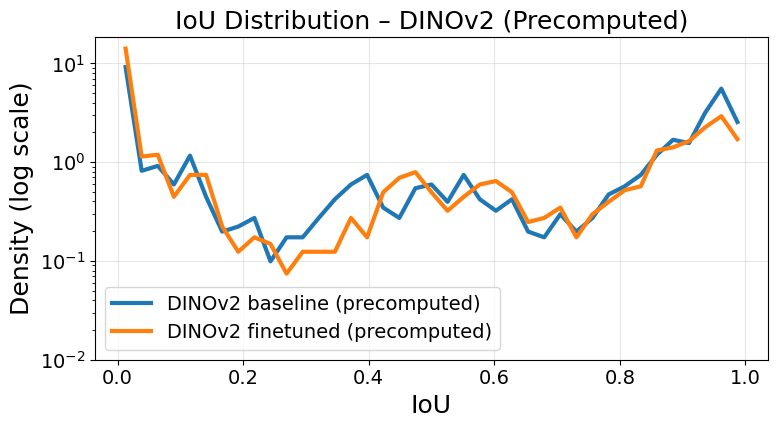

In [288]:
if eval_data["dinov2_baseline"] and eval_data["dinov2_finetuned"]:
    series = {
        eval_data["dinov2_baseline"]["label"]: eval_data["dinov2_baseline"]["iou_per_obs"],
        eval_data["dinov2_finetuned"]["label"]: eval_data["dinov2_finetuned"]["iou_per_obs"],
    }
    plot_iou_distribution(
        series,
        "IoU Distribution – DINOv2 (Precomputed)",
        save_path=plots_dir / "dino" / "dinov2_iou_distribution.png"
    )
else:
    print("⚠ DINOv2 data not available")

### Plot: DINOv2 IoU CDF

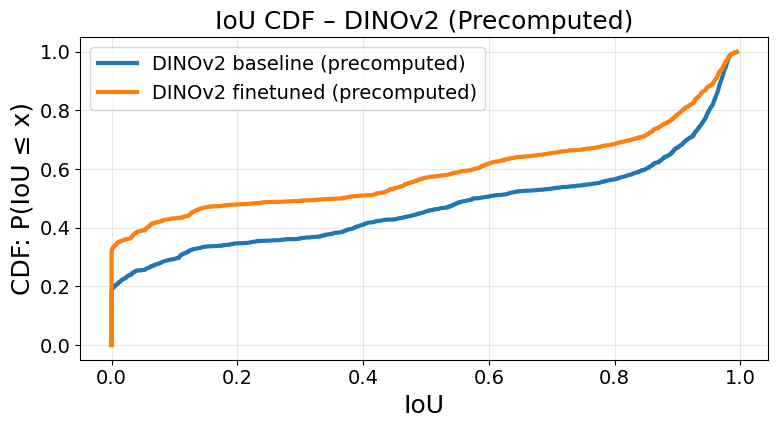

In [289]:
if eval_data["dinov2_baseline"] and eval_data["dinov2_finetuned"]:
    series = {
        eval_data["dinov2_baseline"]["label"]: eval_data["dinov2_baseline"]["iou_per_obs"],
        eval_data["dinov2_finetuned"]["label"]: eval_data["dinov2_finetuned"]["iou_per_obs"],
    }
    plot_iou_cdf(
        series,
        "IoU CDF – DINOv2 (Precomputed)",
        save_path=plots_dir / "dino" / "dinov2_iou_cdf.png"
    )

### Plot: DINOv2 IoU KDE

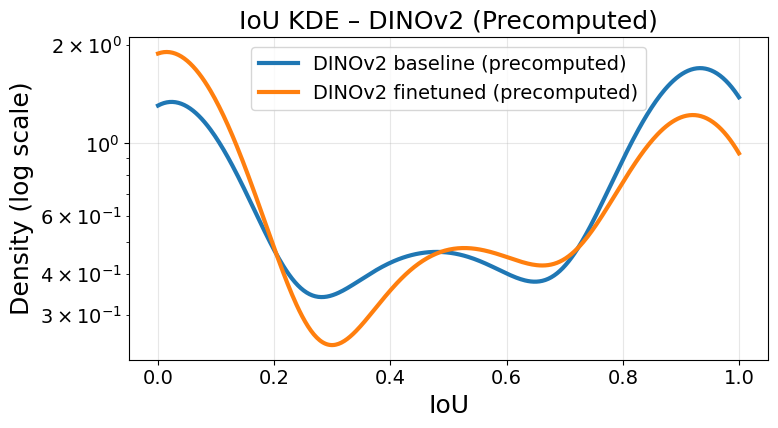

In [290]:
if eval_data["dinov2_baseline"] and eval_data["dinov2_finetuned"]:
    series = {
        eval_data["dinov2_baseline"]["label"]: eval_data["dinov2_baseline"]["iou_per_obs"],
        eval_data["dinov2_finetuned"]["label"]: eval_data["dinov2_finetuned"]["iou_per_obs"],
    }
    plot_iou_kde(
        series,
        "IoU KDE – DINOv2 (Precomputed)",
        save_path=plots_dir / "dino" / "dinov2_iou_kde.png"
    )

### Plot: DINOv2 ΔIoU (Finetuned - Baseline)

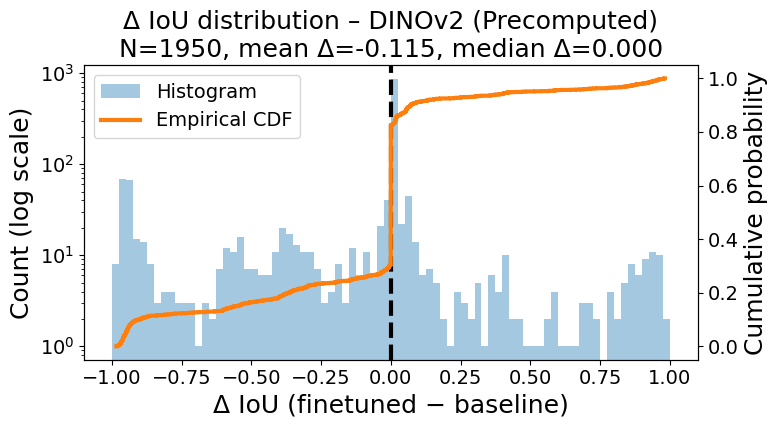

In [291]:
if eval_data["dinov2_baseline"] and eval_data["dinov2_finetuned"]:
    plot_divergent_iou(
        "DINOv2 (Precomputed)",
        eval_data["dinov2_baseline"]["iou_per_obs"],
        eval_data["dinov2_finetuned"]["iou_per_obs"],
        save_path=plots_dir / "dino" / "dinov2_divergent_iou.png"
    )

### Plot: DINOv2 Training Curves

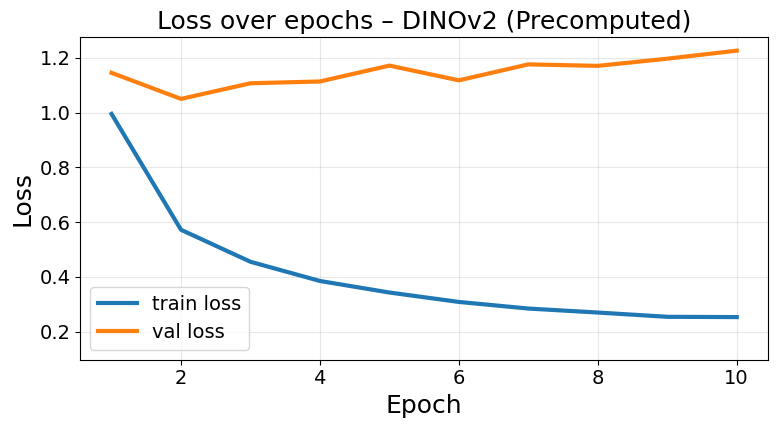

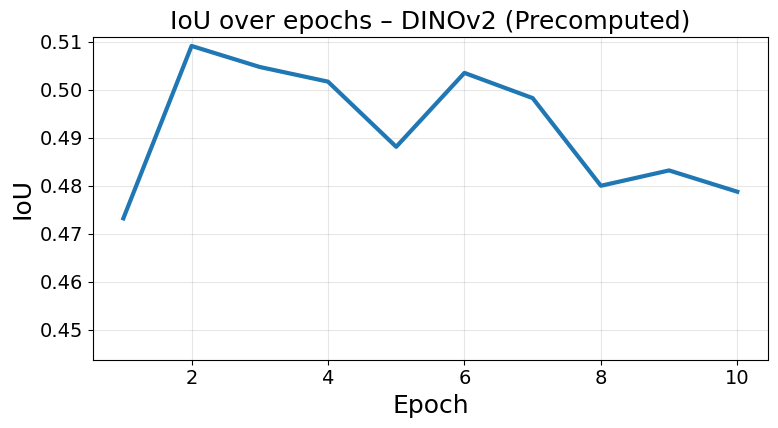

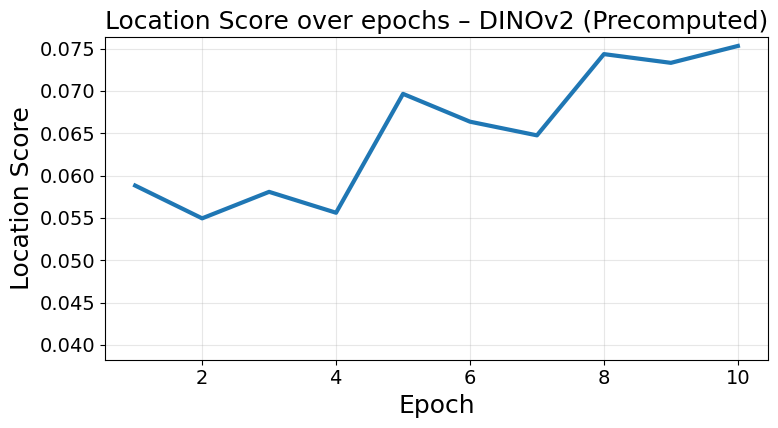

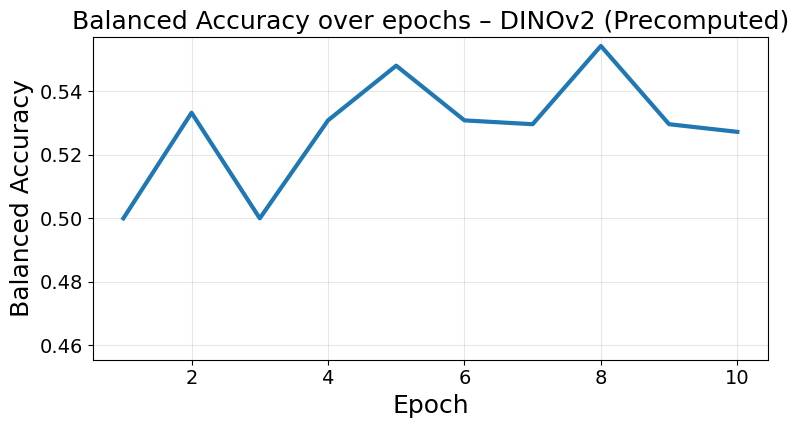

In [292]:
if training_data.get("dinov2"):
    plot_training_curves(
        "DINOv2 (Precomputed)",
        training_data["dinov2"]["train_losses"],
        training_data["dinov2"]["val_losses"],
        training_data["dinov2"]["val_metrics"],
        save_dir=plots_dir / "dino" / "dinov2"
    )
else:
    print("⚠ DINOv2 training data not available")

### Plot: DINOv3 IoU Distribution & Comparisons

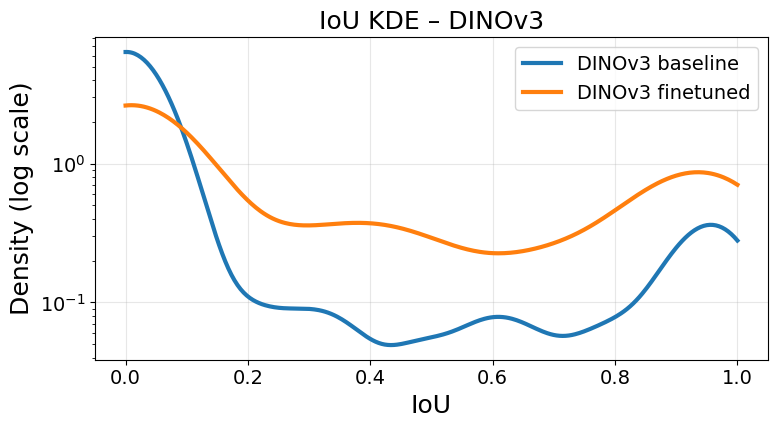

In [293]:
if eval_data["dinov3_baseline"] and eval_data["dinov3_finetuned"]:
    series = {
        eval_data["dinov3_baseline"]["label"]: eval_data["dinov3_baseline"]["iou_per_obs"],
        eval_data["dinov3_finetuned"]["label"]: eval_data["dinov3_finetuned"]["iou_per_obs"],
    }
    plot_iou_kde(
        series,
        "IoU KDE – DINOv3",
        save_path=plots_dir / "dino" / "dinov3_iou_kde.png"
    )
else:
    print("⚠ DINOv3 data not available")

### Plot: DINOv3 ΔIoU

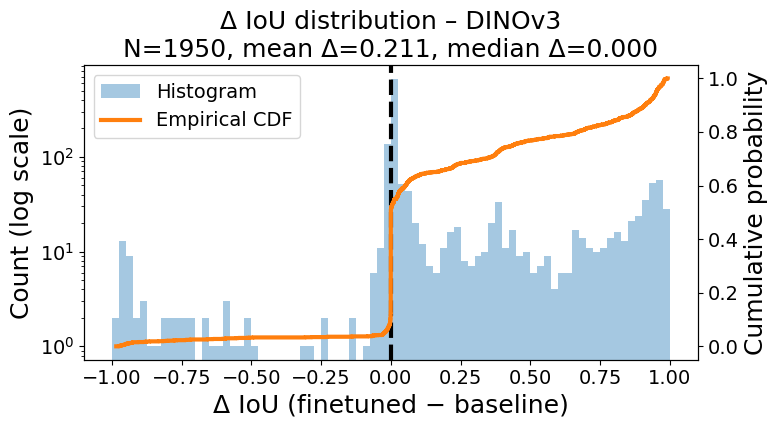

In [294]:
if eval_data["dinov3_baseline"] and eval_data["dinov3_finetuned"]:
    plot_divergent_iou(
        "DINOv3",
        eval_data["dinov3_baseline"]["iou_per_obs"],
        eval_data["dinov3_finetuned"]["iou_per_obs"],
        save_path=plots_dir / "dino" / "dinov3_divergent_iou.png"
    )

### Plot: DINOv3 Training Curves

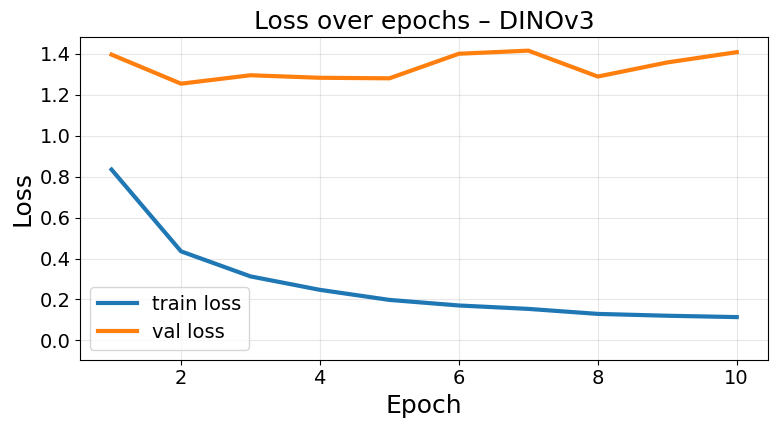

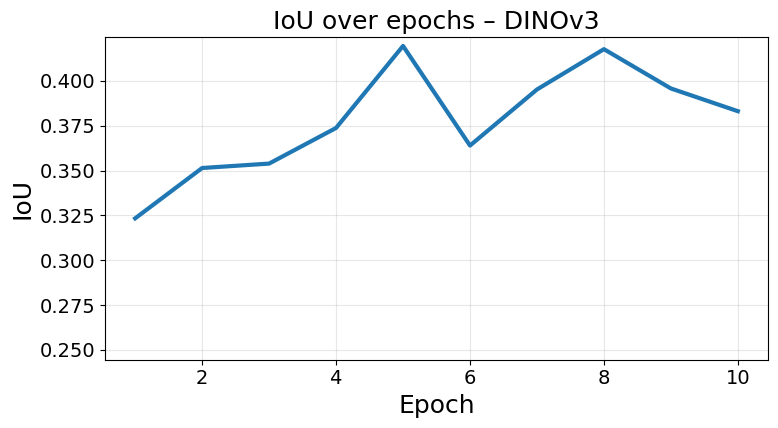

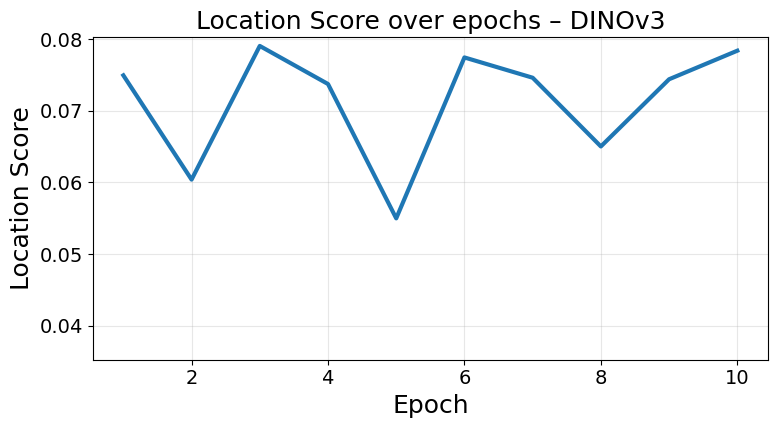

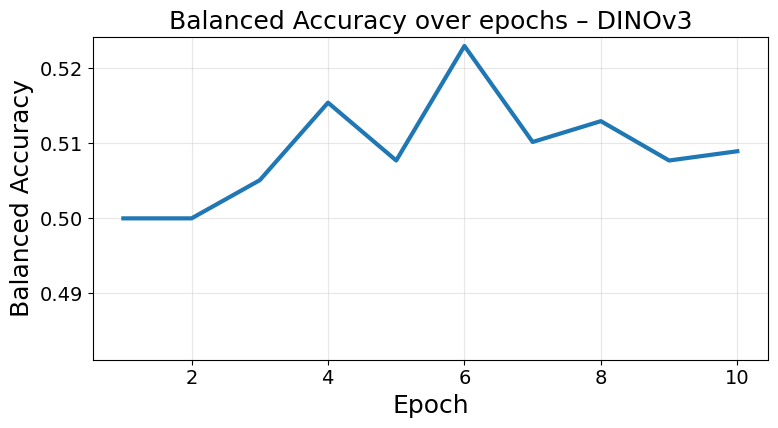

In [295]:
if training_data.get("dinov3"):
    plot_training_curves(
        "DINOv3",
        training_data["dinov3"]["train_losses"],
        training_data["dinov3"]["val_losses"],
        training_data["dinov3"]["val_metrics"],
        save_dir=plots_dir / "dino" / "dinov3"
    )
else:
    print("⚠ DINOv3 training data not available")

---
# RESNET50 + DINOv1 EXPERIMENTS
---

### Plot: ResNet50 IoU Distribution

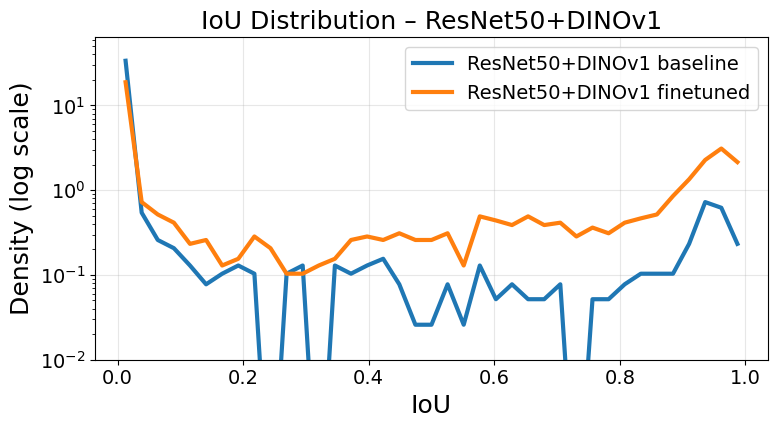

In [296]:
if eval_data["resnet50_baseline"] and eval_data["resnet50_finetuned"]:
    series = {
        eval_data["resnet50_baseline"]["label"]: eval_data["resnet50_baseline"]["iou_per_obs"],
        eval_data["resnet50_finetuned"]["label"]: eval_data["resnet50_finetuned"]["iou_per_obs"],
    }
    plot_iou_distribution(
        series,
        "IoU Distribution – ResNet50+DINOv1",
        save_path=plots_dir / "resnet50" / "resnet50_iou_distribution.png"
    )
else:
    print("⚠ ResNet50 data not available")

### Plot: ResNet50 IoU CDF

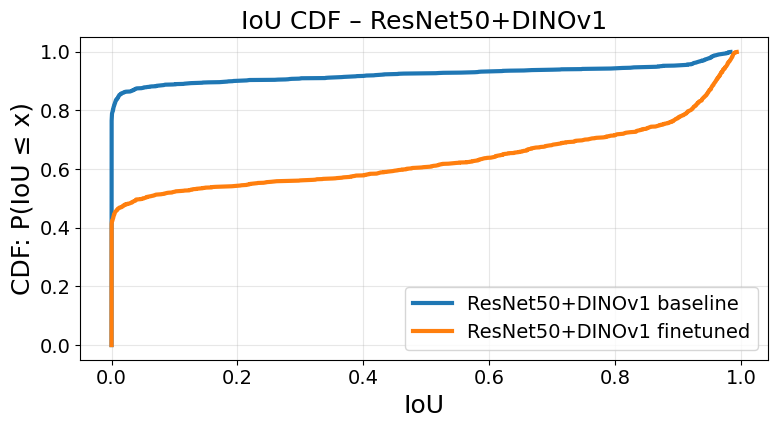

In [297]:
if eval_data["resnet50_baseline"] and eval_data["resnet50_finetuned"]:
    series = {
        eval_data["resnet50_baseline"]["label"]: eval_data["resnet50_baseline"]["iou_per_obs"],
        eval_data["resnet50_finetuned"]["label"]: eval_data["resnet50_finetuned"]["iou_per_obs"],
    }
    plot_iou_cdf(
        series,
        "IoU CDF – ResNet50+DINOv1",
        save_path=plots_dir / "resnet50" / "resnet50_iou_cdf.png"
    )

### Plot: ResNet50 IoU KDE

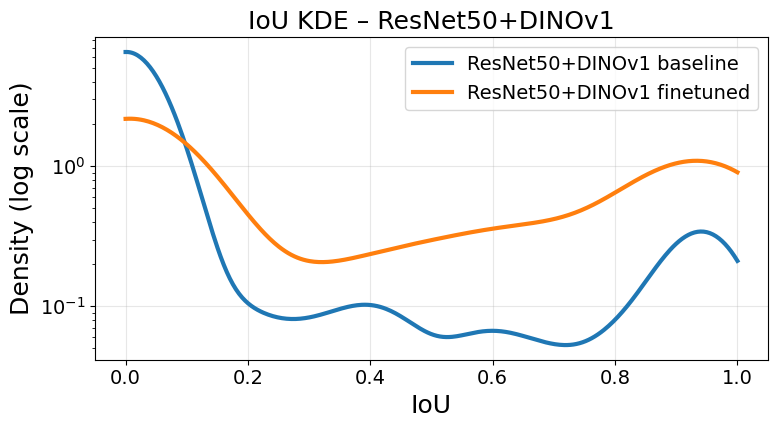

In [298]:
if eval_data["resnet50_baseline"] and eval_data["resnet50_finetuned"]:
    series = {
        eval_data["resnet50_baseline"]["label"]: eval_data["resnet50_baseline"]["iou_per_obs"],
        eval_data["resnet50_finetuned"]["label"]: eval_data["resnet50_finetuned"]["iou_per_obs"],
    }
    plot_iou_kde(
        series,
        "IoU KDE – ResNet50+DINOv1",
        save_path=plots_dir / "resnet50" / "resnet50_iou_kde.png"
    )

### Plot: ResNet50 ΔIoU

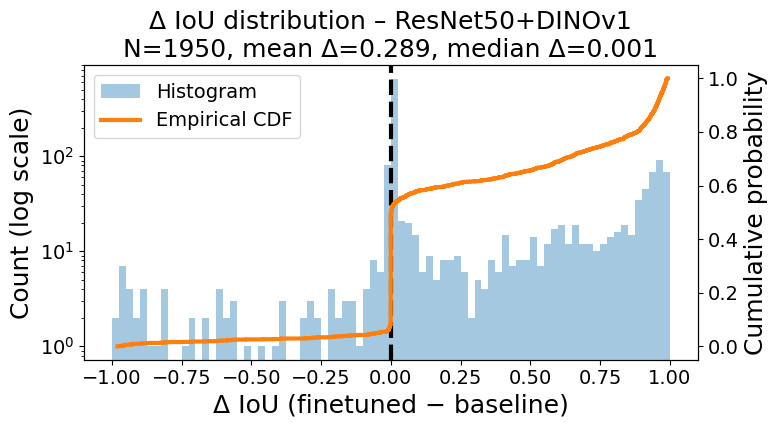

In [299]:
if eval_data["resnet50_baseline"] and eval_data["resnet50_finetuned"]:
    plot_divergent_iou(
        "ResNet50+DINOv1",
        eval_data["resnet50_baseline"]["iou_per_obs"],
        eval_data["resnet50_finetuned"]["iou_per_obs"],
        save_path=plots_dir / "resnet50" / "resnet50_divergent_iou.png"
    )

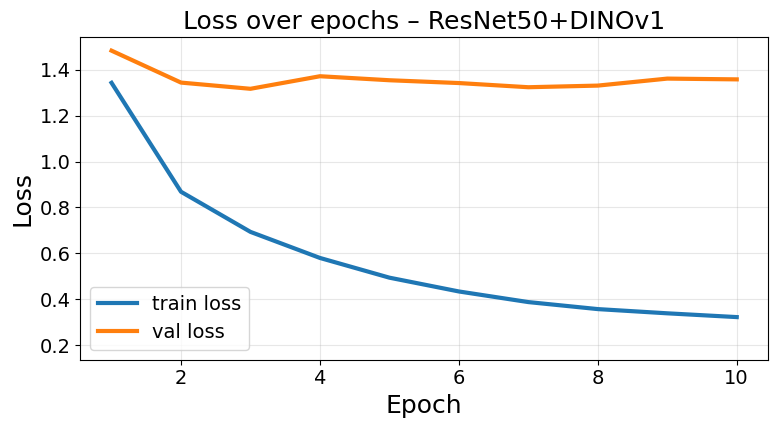

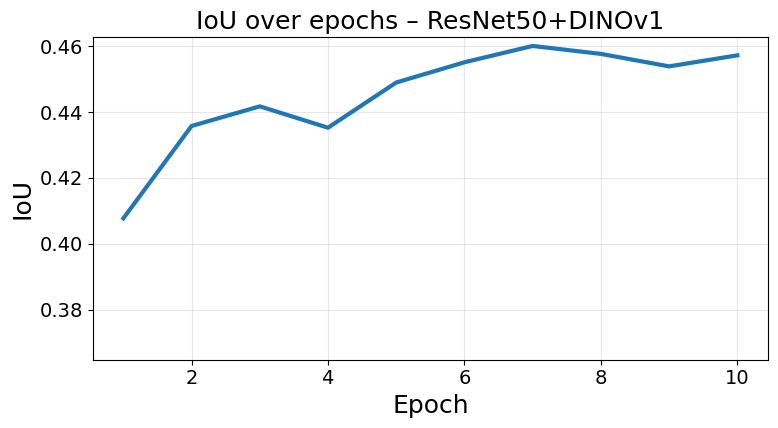

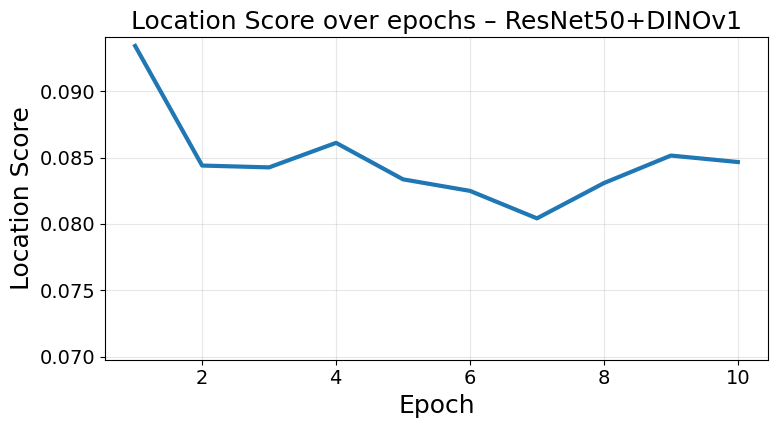

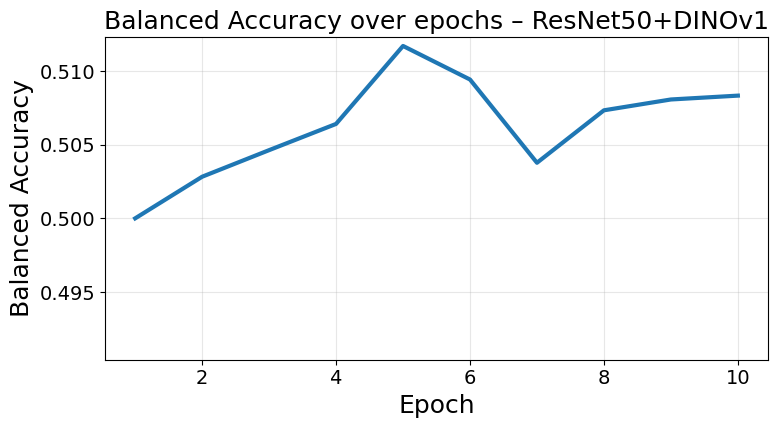

In [300]:
# Load ResNet50 training data
resnet_train_stats = load_training_stats(resnet_dir / "ResNet50-DinoV1_finetuned")

if resnet_train_stats:
    plot_training_curves(
        "ResNet50+DINOv1",
        resnet_train_stats["train_losses"],
        resnet_train_stats["val_losses"],
        resnet_train_stats["val_metrics"],
        save_dir=plots_dir / "resnet50"
    )
else:
    print("⚠ ResNet50 training data not available")

### Plot: ResNet50 Training Curves

---
# DINOv2 ON-THE-FLY EXPERIMENTS
---

### Plot: DINOv2 On-the-Fly IoU KDE (Baseline vs Finetuned)

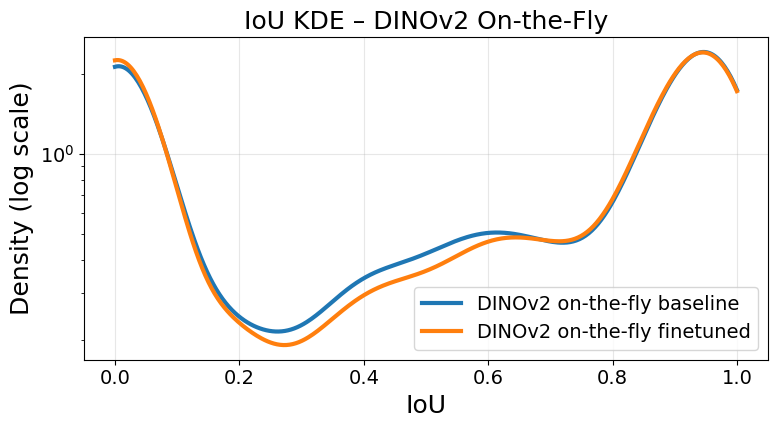

In [301]:
if eval_data["dinov2_otf_baseline"] and eval_data["dinov2_otf_finetuned"]:
    series = {
        eval_data["dinov2_otf_baseline"]["label"]: eval_data["dinov2_otf_baseline"]["iou_per_obs"],
        eval_data["dinov2_otf_finetuned"]["label"]: eval_data["dinov2_otf_finetuned"]["iou_per_obs"],
    }
    plot_iou_kde(
        series,
        "IoU KDE – DINOv2 On-the-Fly",
        save_path=plots_dir / "dinov2_otf" / "dinov2_otf_iou_kde.png"
    )
else:
    print("⚠ DINOv2 on-the-fly data not available")

### Plot: DINOv2 On-the-Fly Training Curves

---
# COMPARATIVE ANALYSIS
---

### Plot: Precomputed vs On-the-Fly DINOv2 Finetuned Comparison

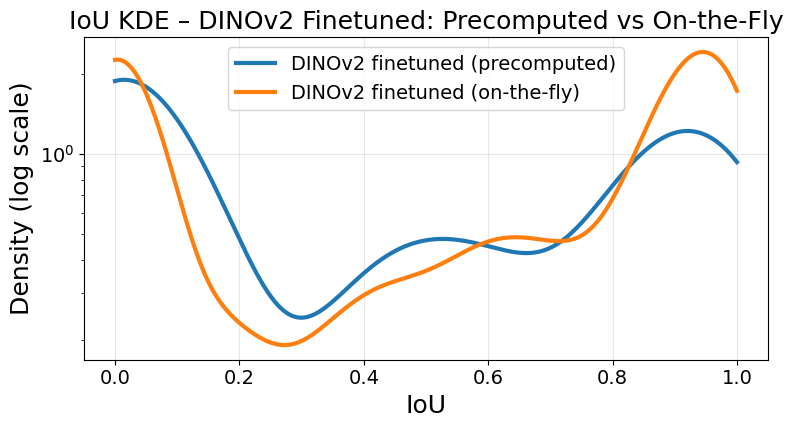

In [303]:
if eval_data["dinov2_finetuned"] and eval_data["dinov2_otf_finetuned"]:
    series = {
        "DINOv2 finetuned (precomputed)": eval_data["dinov2_finetuned"]["iou_per_obs"],
        "DINOv2 finetuned (on-the-fly)": eval_data["dinov2_otf_finetuned"]["iou_per_obs"],
    }
    plot_iou_kde(
        series,
        "IoU KDE – DINOv2 Finetuned: Precomputed vs On-the-Fly",
        save_path=plots_dir / "comparisons" / "dinov2_precomputed_vs_otf_finetuned.png"
    )
else:
    print("⚠ Cannot compare: missing data")

### Plot: All Architectures Baseline Comparison

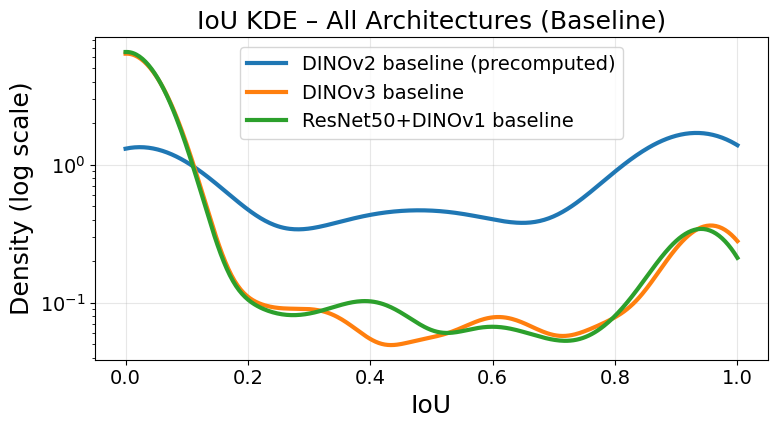

In [304]:
series = {}
for key in ["dinov2_baseline", "dinov3_baseline", "resnet50_baseline"]:
    if eval_data.get(key):
        series[eval_data[key]["label"]] = eval_data[key]["iou_per_obs"]

if series:
    plot_iou_kde(
        series,
        "IoU KDE – All Architectures (Baseline)",
        save_path=plots_dir / "comparisons" / "all_baselines_comparison.png"
    )
else:
    print("⚠ No baseline data available")

### Plot: All Architectures Finetuned Comparison

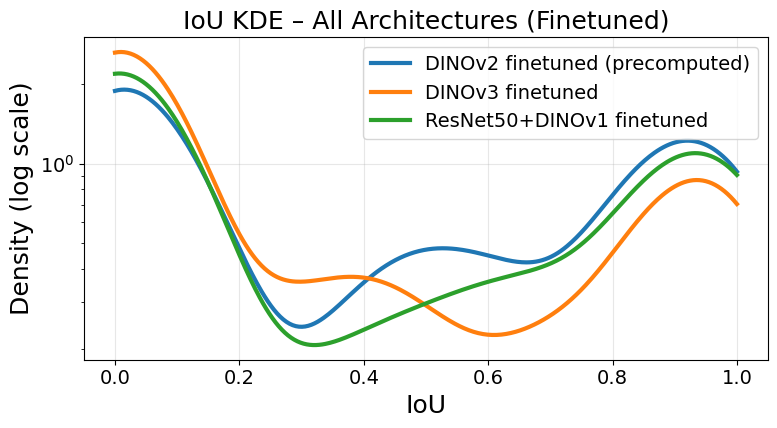

In [305]:
series = {}
for key in ["dinov2_finetuned", "dinov3_finetuned", "resnet50_finetuned"]:
    if eval_data.get(key):
        series[eval_data[key]["label"]] = eval_data[key]["iou_per_obs"]

if series:
    plot_iou_kde(
        series,
        "IoU KDE – All Architectures (Finetuned)",
        save_path=plots_dir / "comparisons" / "all_finetuned_comparison.png"
    )
else:
    print("⚠ No finetuned data available")

---
# SUMMARY TABLES
---

### Table: All Models Evaluation Summary

In [306]:
# Create comprehensive summary table
summary_rows = []
for key, data in eval_data.items():
    if data:
        summary_rows.append({
            "Model": data["label"],
            "IoU": data["mean_iou"],
            "IoU_std": data["iou_std"],
            "Shape_Acc": data["shape_acc"],
            "Location_Score": data["location_score"],
            "Balanced_Acc": data["balanced_acc"],
            "N_obs": data["n_obs"],
        })

if summary_rows:
    df_summary = pd.DataFrame(summary_rows)
    df_summary = df_summary.round(4)
    
    # Remove N_obs column
    df_summary = df_summary.drop(columns=["N_obs"])
    
    # Save to CSV
    df_summary.to_csv(tables_dir / "all_models_summary.csv", index=False)
    
    # Display
    print("=" * 80)
    print("ALL MODELS EVALUATION SUMMARY")
    print("=" * 80)
    display(df_summary)
    
    # Highlight best performers
    print("\n🏆 Best Performers:")
    print(f"  Highest IoU: {df_summary.loc[df_summary['IoU'].idxmax(), 'Model']} ({df_summary['IoU'].max():.4f})")
    print(f"  Lowest IoU_std: {df_summary.loc[df_summary['IoU_std'].idxmin(), 'Model']} ({df_summary['IoU_std'].min():.4f})")
    
    # Generate LaTeX table
    print("\n" + "=" * 80)
    print("LATEX TABLE CODE")
    print("=" * 80)
    print(r"\begin{table}[!htbp]")
    print(r"\centering")
    print(r"\begin{tabular}{l" + "c" * (len(df_summary.columns) - 1) + "}")
    print(r"\toprule")
    
    # Header row
    header = "Model"
    for col in df_summary.columns[1:]:
        if col == "IoU":
            header += r" & IoU $\uparrow$"
        elif col == "IoU_std":
            header += r" & IoU Std $\downarrow$"
        elif col == "Shape_Acc":
            header += r" & Shape Acc $\uparrow$"
        elif col == "Location_Score":
            header += r" & Location Score $\uparrow$"
        elif col == "Balanced_Acc":
            header += r" & Balanced Acc $\uparrow$"
        else:
            header += f" & {col}"
    header += r" \\"
    print(header)
    print(r"\midrule")
    
    # Data rows
    for _, row in df_summary.iterrows():
        line = row["Model"]
        for col in df_summary.columns[1:]:
            line += f" & {row[col]:.4f}"
        line += r" \\"
        print(line)
    
    print(r"\bottomrule")
    print(r"\end{tabular}")
    print(r"\caption{\textbf{All models evaluation summary.} Comparison of different architectures and training configurations.}")
    print(r"\label{tab:all-models-summary}")
    print(r"\end{table}")
else:
    print("⚠ No data available for summary table")

ALL MODELS EVALUATION SUMMARY


,Model,IoU,IoU_std,Shape_Acc,Location_Score,Balanced_Acc
0,DINOv2 baseline (precomputed),0.5262,0.4036,0.6241,0.0375,0.5193
1,DINOv2 finetuned (precomputed),0.4108,0.4044,0.4965,0.0534,0.5386
2,DINOv3 baseline,0.0791,0.2405,0.1171,0.1799,0.5000
3,DINOv3 finetuned,0.2897,0.3819,0.3869,0.0836,0.5000
4,ResNet50+DINOv1 baseline,0.0757,0.2315,0.1061,0.2235,0.5000
5,ResNet50+DINOv1 finetuned,0.3647,0.4140,0.4225,0.0775,0.5287
6,DINOv2 on-the-fly baseline,0.5332,0.4084,0.5905,0.0490,0.5224
7,DINOv2 on-the-fly finetuned,0.5263,0.4145,0.5891,0.0502,0.5944



🏆 Best Performers:
  Highest IoU: DINOv2 on-the-fly baseline (0.5332)
  Lowest IoU_std: ResNet50+DINOv1 baseline (0.2315)

LATEX TABLE CODE
\begin{table}[!htbp]
\centering
\begin{tabular}{lccccc}
\toprule
Model & IoU $\uparrow$ & IoU Std $\downarrow$ & Shape Acc $\uparrow$ & Location Score $\uparrow$ & Balanced Acc $\uparrow$ \\
\midrule
DINOv2 baseline (precomputed) & 0.5262 & 0.4036 & 0.6241 & 0.0375 & 0.5193 \\
DINOv2 finetuned (precomputed) & 0.4108 & 0.4044 & 0.4965 & 0.0534 & 0.5386 \\
DINOv3 baseline & 0.0791 & 0.2405 & 0.1171 & 0.1799 & 0.5000 \\
DINOv3 finetuned & 0.2897 & 0.3819 & 0.3869 & 0.0836 & 0.5000 \\
ResNet50+DINOv1 baseline & 0.0757 & 0.2315 & 0.1061 & 0.2235 & 0.5000 \\
ResNet50+DINOv1 finetuned & 0.3647 & 0.4140 & 0.4225 & 0.0775 & 0.5287 \\
DINOv2 on-the-fly baseline & 0.5332 & 0.4084 & 0.5905 & 0.0490 & 0.5224 \\
DINOv2 on-the-fly finetuned & 0.5263 & 0.4145 & 0.5891 & 0.0502 & 0.5944 \\
\bottomrule
\end{tabular}
\caption{\textbf{All models evaluation summary.} 

### Table: Delta IoU (Finetuned - Baseline) Summary